In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/Dane
!unzip "/content/drive/My Drive/czerniakData.zip" -d "/content/Dane"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/Dane/data/train/benign/420.jpg  
  inflating: /content/Dane/data/train/benign/421.jpg  
  inflating: /content/Dane/data/train/benign/422.jpg  
  inflating: /content/Dane/data/train/benign/423.jpg  
  inflating: /content/Dane/data/train/benign/424.jpg  
  inflating: /content/Dane/data/train/benign/425.jpg  
  inflating: /content/Dane/data/train/benign/426.jpg  
  inflating: /content/Dane/data/train/benign/429.jpg  
  inflating: /content/Dane/data/train/benign/43.jpg  
  inflating: /content/Dane/data/train/benign/430.jpg  
  inflating: /content/Dane/data/train/benign/431.jpg  
  inflating: /content/Dane/data/train/benign/432.jpg  
  inflating: /content/Dane/data/train/benign/434.jpg  
  inflating: /content/Dane/data/train/benign/435.jpg  
  inflating: /content/Dane/data/train/benign/438.jpg  
  inflating: /content/Dane/data/train/benign/439.jpg  
  inflating: /content/Dane/data/train/benign/440.jpg  
 

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode
import torch
import os
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
TrainTransform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

ValTransform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
data_dir = '/content/Dane/data'

trainDataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), TrainTransform)
valDataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'), ValTransform)


In [ ]:

trainDataLoader = torch.utils.data.DataLoader(trainDataset, batch_size = 4, shuffle=True, num_workers=2)
valDataLoader = torch.utils.data.DataLoader(valDataset, batch_size = 4, shuffle=True, num_workers=2)

In [ ]:
trainDataLoader

In [ ]:
len(trainDataset), len(valDataset)

(2637, 660)

In [ ]:
class_names = trainDataset.classes
class_names

['benign', 'malignant']

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
inputs, classes = next(iter(trainDataLoader))

out = torchvision.utils.make_grid(inputs.to(device))

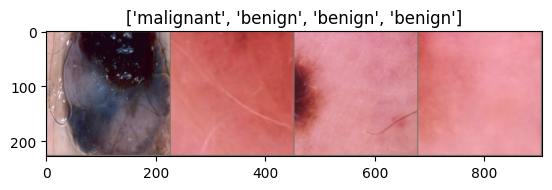

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    czasPoczatkowy = time.time()
    najlepszyModel = copy.deepcopy(model.state_dict())
    najwyzszaAccuracy = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        #trenowanie
        model.train()

        obecnyLoss = 0.0
        dobrzeOkreslone = 0

        for obraz, opis in trainDataLoader:
            obraz = obraz.to(device)
            opis = opis.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                wynik = model(obraz)
                _, predykcja = torch.max(wynik, 1)
                loss = criterion(wynik, opis)

                loss.backward()
                optimizer.step()

            obecnyLoss += loss.item() * obraz.size(0)
            dobrzeOkreslone += torch.sum(predykcja == opis.data)

        scheduler.step()

        epokaLoss = obecnyLoss / len(trainDataset)
        epokaAcc = dobrzeOkreslone.double() / len(trainDataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'treningowa', epokaLoss, epokaAcc))


        #walidacja
        model.eval()

        obecnyLoss = 0.0
        dobrzeOkreslone = 0

        for obraz, opis in valDataLoader:
            obraz = obraz.to(device)
            opis = opis.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                wynik = model(obraz)
                _, predykcja = torch.max(wynik, 1)
                loss = criterion(wynik, opis)

            obecnyLoss += loss.item() * obraz.size(0)
            dobrzeOkreslone += torch.sum(predykcja == opis.data)

        epokaLoss = obecnyLoss / len(valDataset)
        epokaAcc = dobrzeOkreslone.double() / len(valDataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'walidacyjna', epokaLoss, epokaAcc))

        if epokaAcc > najwyzszaAccuracy:
              najwyzszaAccuracy = epokaAcc
              najlepszyModel = copy.deepcopy(model.state_dict())

        print()

    calkowityCzas = time.time() - czasPoczatkowy
    print('Training complete in {:.0f}m {:.0f}s'.format(
    calkowityCzas // 60, calkowityCzas % 60))
    print('Best val Acc: {:4f}'.format(najwyzszaAccuracy))

    model.load_state_dict(najlepszyModel)
    return model

In [ ]:
model_ft = models.resnet18(weights=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

NameError: name 'models' is not defined

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


In [ ]:
torch.save(model_ft.state_dict(), 'nowyResNetCzerniak.pth')
print("Model został zapisany!")

NameError: name 'torch' is not defined

In [ ]:

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Zakładamy, że masz model i test_loader
model_ft.eval()
WszyscyPredykcje = []
WszystkieOpisy = []

with torch.no_grad():
    for obrazy, opisy in valDataLoader:
        obrazy = obrazy.to(device)
        opisy = opisy.to(device)
        wynik = model_ft(obrazy)
        _, predykcja = torch.max(wynik, 1)
        WszyscyPredykcje.extend(predykcja.cpu().numpy())
        WszystkieOpisy.extend(opisy.cpu().numpy())

# Oblicz confusion matrix
cm = confusion_matrix(WszystkieOpisy, WszyscyPredykcje)


# Wyświetl confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Macierz pomyłek")
plt.show()

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_ft.eval()
wszystkie_prob_klasa1 = []
wszystkie_opisy = []

with torch.no_grad():
    for obrazy, opisy in valDataLoader:
        obrazy = obrazy.to(device)
        opisy = opisy.to(device)
        wyniki = model_ft(obrazy)  # shape: [batch_size, 2]

        # Softmax i wybór prawdopodobieństwa klasy 1 (nowotworowej)
        probs = F.softmax(wyniki, dim=1)[:, 1]  # tylko prawdopodobieństwa klasy 1
        wszystkie_prob_klasa1.extend(probs.cpu().numpy())
        wszystkie_opisy.extend(opisy.cpu().numpy())

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

model_ft.eval()
wszystkie_prob_klasa1 = []
wszystkie_opisy = []

with torch.no_grad():
    for obrazy, opisy in valDataLoader:
        obrazy = obrazy.to(device)
        opisy = opisy.to(device)
        wyniki = model_ft(obrazy)  # shape: [batch_size, 2]

        # Softmax i wybór prawdopodobieństwa klasy 1 (np. nowotworowej)
        probs = F.softmax(wyniki, dim=1)[:, 1]  # tylko dla klasy 1
        wszystkie_prob_klasa1.extend(probs.cpu().numpy())
        wszystkie_opisy.extend(opisy.cpu().numpy())

# Obliczenie krzywej ROC i AUC
wszystkie_opisy = np.array(wszystkie_opisy)
wszystkie_prob_klasa1 = np.array(wszystkie_prob_klasa1)

fałszywe_pozytywy, prawdziwe_pozytywy, progi = roc_curve(wszystkie_opisy, wszystkie_prob_klasa1)
pole_pod_krzywą = auc(fałszywe_pozytywy, prawdziwe_pozytywy)

# Rysowanie wykresu
plt.figure(figsize=(6, 6))
plt.plot(fałszywe_pozytywy, prawdziwe_pozytywy, color='blue', label=f"Krzywa ROC (AUC = {pole_pod_krzywą:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # linia losowa
plt.xlabel("Współczynnik fałszywych pozytywów (FPR)")
plt.ylabel("Współczynnik prawdziwych pozytywów (TPR)")
plt.title("Krzywa ROC")
plt.legend()
plt.grid()
plt.show()